Using device: cuda
Scanning RAVDESS audio files...


  0%|          | 0/24 [00:00<?, ?it/s]

Loaded files: 1440
                                                path emotion_label  actor_id
0  c:\Users\Suyas\Downloads\audio analysis\audio_...       neutral         1
1  c:\Users\Suyas\Downloads\audio analysis\audio_...       neutral         1
2  c:\Users\Suyas\Downloads\audio analysis\audio_...       neutral         1
3  c:\Users\Suyas\Downloads\audio analysis\audio_...       neutral         1
4  c:\Users\Suyas\Downloads\audio analysis\audio_...          calm         1
Classes: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Label map: {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}

Class distribution:
emotion_label
calm         192
happy        192
sad          192
angry        192
disgust      192
fearful      192
surprised    192
neutral       96
Name: count, dtype: int64

Train: 1008 | Val: 216 | Test: 216
Class weights: tensor([0.8867, 0.8867, 0.8933, 0.8933, 0.8933, 1.7603, 0.8933, 0.8

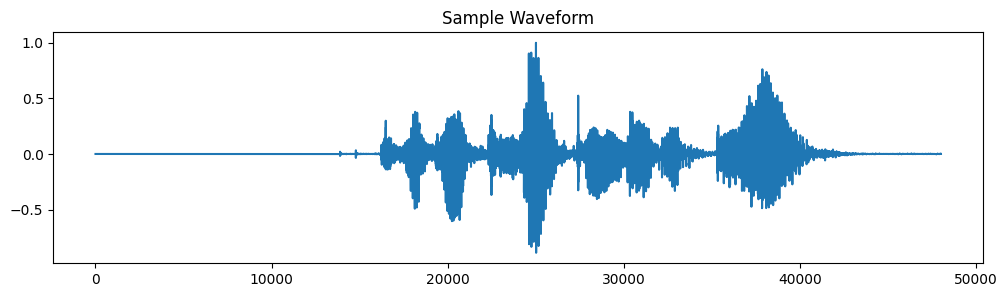

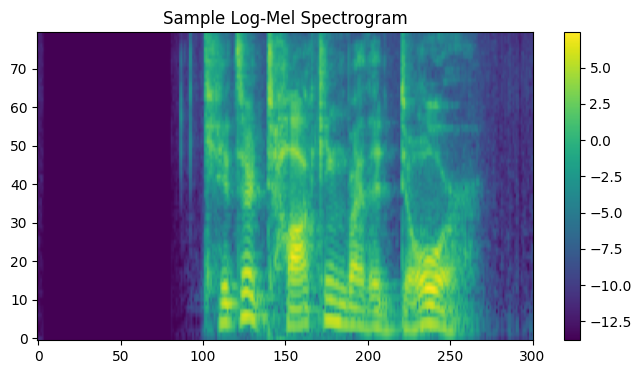

In [1]:
# =========================
# CELL 1 (IMPROVED): Imports + Dataset Scan + Split + Visualization
# =========================

import os, re, random, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm.auto import tqdm

%matplotlib inline

# Repro
RANDOM_SEED_AUDIO = 42
random.seed(RANDOM_SEED_AUDIO)
np.random.seed(RANDOM_SEED_AUDIO)
torch.manual_seed(RANDOM_SEED_AUDIO)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED_AUDIO)

audio_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", audio_device)

# -------------------------
# Audio params
# -------------------------
TARGET_SAMPLE_RATE = 16000
AUDIO_DURATION = 3.0
TARGET_NUM_SAMPLES = int(TARGET_SAMPLE_RATE * AUDIO_DURATION)

N_MELS = 80
N_FFT = 512
HOP_LENGTH = 160
FMIN, FMAX = 20, 8000

# -------------------------
# RAVDESS paths
# -------------------------
RAVDESS_ROOT_DIR = "."
audio_speech_dir = os.path.join(RAVDESS_ROOT_DIR, "audio_speech_actors_01-24")
if not os.path.exists(audio_speech_dir):
    raise FileNotFoundError(f"RAVDESS folder not found: {os.path.abspath(audio_speech_dir)}")

emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

ravdess_data = []
filename_pattern = re.compile(r'(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})\.wav')

print("Scanning RAVDESS audio files...")
for actor_folder in tqdm(sorted(os.listdir(audio_speech_dir))):
    actor_path = os.path.join(audio_speech_dir, actor_folder)
    if not os.path.isdir(actor_path):
        continue
    for filename in os.listdir(actor_path):
        if not filename.endswith(".wav"):
            continue
        match = filename_pattern.match(filename)
        if not match:
            continue

        parts = match.groups()
        emotion_id = parts[2]
        actor_id = parts[6]
        emotion_label = emotion_map.get(emotion_id, "unknown")

        full_path = os.path.abspath(os.path.join(actor_path, filename))
        ravdess_data.append({
            "path": full_path,
            "emotion_label": emotion_label,
            "actor_id": int(actor_id)
        })

ravdess_df = pd.DataFrame(ravdess_data)
print("Loaded files:", len(ravdess_df))
print(ravdess_df.head())

emotion_class_names = sorted(ravdess_df["emotion_label"].unique())
emotion_label_to_id = {c:i for i,c in enumerate(emotion_class_names)}
ravdess_df["emotion_id_numeric"] = ravdess_df["emotion_label"].map(emotion_label_to_id)

print("Classes:", emotion_class_names)
print("Label map:", emotion_label_to_id)
print("\nClass distribution:")
print(ravdess_df["emotion_label"].value_counts())

# -------------------------
# Split (70/15/15 stratified)
# -------------------------
train_val_df, test_df_audio = train_test_split(
    ravdess_df, test_size=0.15, random_state=RANDOM_SEED_AUDIO,
    stratify=ravdess_df["emotion_id_numeric"]
)
train_df_audio, val_df_audio = train_test_split(
    train_val_df, test_size=0.176, random_state=RANDOM_SEED_AUDIO,
    stratify=train_val_df["emotion_id_numeric"]
)

print(f"\nTrain: {len(train_df_audio)} | Val: {len(val_df_audio)} | Test: {len(test_df_audio)}")

# -------------------------
# Class weights (for CNN loss)
# -------------------------
counts = Counter(train_df_audio["emotion_id_numeric"])
class_weights_audio = torch.tensor(
    [1.0 / counts[i] for i in range(len(emotion_class_names))],
    dtype=torch.float32
)
class_weights_audio = class_weights_audio / class_weights_audio.sum() * len(emotion_class_names)
print("Class weights:", class_weights_audio)

# -------------------------
# Quick waveform + mel viz
# -------------------------
sample_path = test_df_audio.sample(1, random_state=RANDOM_SEED_AUDIO).iloc[0]["path"]
waveform, sr = torchaudio.load(sample_path)

if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

if sr != TARGET_SAMPLE_RATE:
    waveform = T.Resample(sr, TARGET_SAMPLE_RATE)(waveform)
    sr = TARGET_SAMPLE_RATE

waveform = waveform / (waveform.abs().max() + 1e-9)

if waveform.shape[1] < TARGET_NUM_SAMPLES:
    waveform = F.pad(waveform, (0, TARGET_NUM_SAMPLES - waveform.shape[1]))
else:
    waveform = waveform[:, :TARGET_NUM_SAMPLES]

mel_transform = T.MelSpectrogram(
    sample_rate=sr, n_fft=N_FFT, hop_length=HOP_LENGTH,
    n_mels=N_MELS, f_min=FMIN, f_max=FMAX
)
mel = mel_transform(waveform)
mel_db = torch.log(mel + 1e-6)

plt.figure(figsize=(12,3))
plt.plot(waveform.squeeze().numpy())
plt.title("Sample Waveform")
plt.show()

plt.figure(figsize=(8,4))
plt.imshow(mel_db.squeeze().numpy(), origin="lower", aspect="auto")
plt.title("Sample Log-Mel Spectrogram")
plt.colorbar()
plt.show()


In [2]:
# =========================
# CELL 2 (IMPROVED): Dataset class for both models
# =========================

time_mask = T.TimeMasking(time_mask_param=30)
freq_mask = T.FrequencyMasking(freq_mask_param=10)

class RAVDESS_AudioDataset(Dataset):
    def __init__(self, df, mode="raw", train=False):
        """
        mode="raw" -> returns waveform for Wav2Vec2
        mode="mel" -> returns log-mel spectrogram for CNN
        train=True -> SpecAugment + tiny noise for mel mode
        """
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.train = train

        self.mel_transform = T.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS,
            f_min=FMIN, f_max=FMAX
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]["path"]
        label = int(self.df.iloc[idx]["emotion_id_numeric"])

        waveform, sr = torchaudio.load(path)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        if sr != TARGET_SAMPLE_RATE:
            waveform = T.Resample(sr, TARGET_SAMPLE_RATE)(waveform)

        waveform = waveform / (waveform.abs().max() + 1e-9)

        # pad/truncate
        if waveform.shape[1] < TARGET_NUM_SAMPLES:
            waveform = F.pad(waveform, (0, TARGET_NUM_SAMPLES - waveform.shape[1]))
        else:
            waveform = waveform[:, :TARGET_NUM_SAMPLES]

        # RAW for Wav2Vec2
        if self.mode == "raw":
            return waveform.squeeze(0), label

        # MEL for CNN
        if self.train:
            waveform = waveform + 0.003 * torch.randn_like(waveform)

        mel = self.mel_transform(waveform)
        mel = torch.log(mel + 1e-6)

        # per-sample norm
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)

        if self.train:
            mel = time_mask(mel)
            mel = freq_mask(mel)

        return mel, label


BATCH_SIZE_AUDIO = 16  # wav2vec is heavier
NUM_WORKERS_AUDIO = 0

train_raw_ds = RAVDESS_AudioDataset(train_df_audio, mode="raw", train=False)
val_raw_ds   = RAVDESS_AudioDataset(val_df_audio, mode="raw", train=False)
test_raw_ds  = RAVDESS_AudioDataset(test_df_audio, mode="raw", train=False)

train_mel_ds = RAVDESS_AudioDataset(train_df_audio, mode="mel", train=True)
val_mel_ds   = RAVDESS_AudioDataset(val_df_audio, mode="mel", train=False)
test_mel_ds  = RAVDESS_AudioDataset(test_df_audio, mode="mel", train=False)

train_raw_loader = DataLoader(train_raw_ds, batch_size=BATCH_SIZE_AUDIO, shuffle=True, num_workers=NUM_WORKERS_AUDIO)
val_raw_loader   = DataLoader(val_raw_ds, batch_size=BATCH_SIZE_AUDIO, shuffle=False, num_workers=NUM_WORKERS_AUDIO)
test_raw_loader  = DataLoader(test_raw_ds, batch_size=BATCH_SIZE_AUDIO, shuffle=False, num_workers=NUM_WORKERS_AUDIO)

train_mel_loader = DataLoader(train_mel_ds, batch_size=32, shuffle=True, num_workers=0)
val_mel_loader   = DataLoader(val_mel_ds, batch_size=32, shuffle=False, num_workers=0)
test_mel_loader  = DataLoader(test_mel_ds, batch_size=32, shuffle=False, num_workers=0)

print("Raw batch:", next(iter(train_raw_loader))[0].shape)
print("Mel batch:", next(iter(train_mel_loader))[0].shape)


Raw batch: torch.Size([16, 48000])
Mel batch: torch.Size([32, 1, 80, 301])


In [3]:
# =========================
# CELL 3: Wav2Vec2 Model + Training (FINAL FIXED FOR YOUR PYTORCH VERSION)
# + PATCHED to store history for graphs (Cell 6)
# =========================

print("\n--- CELL 3: Wav2Vec2 Training (Fixed for PyTorch < 2.0) ---")

import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, Wav2Vec2ForSequenceClassification
import torch.nn.functional as F
from tqdm.notebook import tqdm

# FIX: correct AdamW import
from torch.optim import AdamW

# FIX: correct autocast import for older PyTorch
from torch.cuda.amp import autocast, GradScaler

# -------------------------
# 0. CONFIG
# -------------------------
SAMPLE_RATE = 16000
AUDIO_DURATION = 3
TARGET_LEN = SAMPLE_RATE * AUDIO_DURATION

BATCH_SIZE_W2V = 8
NUM_EPOCHS_W2V = 12
LR_W2V = 2e-5

audio_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", audio_device)

# -------------------------
# PATCH 0. HISTORY TRACKING (for Cell 6 curves)
# -------------------------
history_w2v = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# -------------------------
# 1. RAW AUDIO DATASET
# -------------------------
class RAVDESSRawDataset(Dataset):
    def __init__(self, df, label_map):
        self.df = df.reset_index(drop=True)
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        label_str = self.df.loc[idx, "emotion_label"]
        label = self.label_map[label_str]

        wav, sr = torchaudio.load(path)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)

        if sr != SAMPLE_RATE:
            wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)

        wav = wav.squeeze(0)
        wav = wav / (wav.abs().max() + 1e-9)

        return wav, label

# -------------------------
# 2. COLLATE FN 
# -------------------------
processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base")

def w2v_collate(batch):
    waves, labels = zip(*batch)
    waves = [w.numpy() for w in waves]

    inputs = processor(
        waves,
        sampling_rate=SAMPLE_RATE,
        return_tensors="pt",
        padding=True
    )

    input_values = inputs["input_values"]

    # FIX: Older HF versions don't return attention_mask
    if "attention_mask" in inputs:
        attention_mask = inputs["attention_mask"]
    else:
        attention_mask = torch.ones_like(input_values, dtype=torch.long)

    labels = torch.tensor(labels, dtype=torch.long)
    return input_values, attention_mask, labels

# -------------------------
# 3. DATA LOADERS
# -------------------------
train_raw_ds = RAVDESSRawDataset(train_df_audio, emotion_label_to_id)
val_raw_ds   = RAVDESSRawDataset(val_df_audio, emotion_label_to_id)
test_raw_ds  = RAVDESSRawDataset(test_df_audio, emotion_label_to_id)

train_raw_loader = DataLoader(train_raw_ds, batch_size=BATCH_SIZE_W2V, shuffle=True, collate_fn=w2v_collate)
val_raw_loader   = DataLoader(val_raw_ds, batch_size=BATCH_SIZE_W2V, shuffle=False, collate_fn=w2v_collate)
test_raw_loader  = DataLoader(test_raw_ds, batch_size=BATCH_SIZE_W2V, shuffle=False, collate_fn=w2v_collate)

print("Train batches:", len(train_raw_loader))

# -------------------------
# 4. MODEL
# -------------------------
num_classes = len(emotion_class_names)
wav2vec_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=num_classes
).to(audio_device)

optimizer = AdamW(wav2vec_model.parameters(), lr=LR_W2V)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()   # works for all versions

print("\n--- Training Wav2Vec2 ---")

best_val_acc = 0.0
best_state = None

for epoch in range(NUM_EPOCHS_W2V):

    # -------- TRAIN --------
    wav2vec_model.train()
    train_loss, correct, total = 0, 0, 0

    for input_values, attn_mask, labels in tqdm(train_raw_loader, desc=f"W2V Epoch {epoch+1}/{NUM_EPOCHS_W2V} Train"):
        input_values = input_values.to(audio_device)
        attn_mask = attn_mask.to(audio_device)
        labels = labels.to(audio_device)

        optimizer.zero_grad()

        with autocast():
            logits = wav2vec_model(
                input_values=input_values,
                attention_mask=attn_mask
            ).logits
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss /= len(train_raw_loader)

    # -------- VAL --------
    wav2vec_model.eval()
    correct, total = 0, 0
    val_loss = 0

    with torch.no_grad():
        for input_values, attn_mask, labels in tqdm(val_raw_loader, desc=f"W2V Epoch {epoch+1}/{NUM_EPOCHS_W2V} Val"):
            input_values = input_values.to(audio_device)
            attn_mask = attn_mask.to(audio_device)
            labels = labels.to(audio_device)

            logits = wav2vec_model(input_values=input_values, attention_mask=attn_mask).logits
            loss = criterion(logits, labels)

            val_loss += loss.item()
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss /= len(val_raw_loader)

    # -------------------------
    # PATCH 1. SAVE HISTORY PER EPOCH
    # -------------------------
    history_w2v["train_loss"].append(train_loss)
    history_w2v["train_acc"].append(train_acc)
    history_w2v["val_loss"].append(val_loss)
    history_w2v["val_acc"].append(val_acc)

    print(f"\nEpoch {epoch+1}: Train Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu() for k, v in wav2vec_model.state_dict().items()}
        print("✔️ New best model saved!")

if best_state:
    wav2vec_model.load_state_dict(best_state)
    wav2vec_model.to(audio_device)

print("\n--- Wav2Vec2 Training Complete ---")
print("Best Val Accuracy:", best_val_acc)

# -------------------------
# PATCH 2. MAKE GLOBALS FOR CELL 5/6
# -------------------------
globals()["history_w2v"] = history_w2v
trained_wav2vec_model = wav2vec_model
globals()["trained_wav2vec_model"] = trained_wav2vec_model



--- CELL 3: Wav2Vec2 Training (Fixed for PyTorch < 2.0) ---
Using device: cuda


c:\Users\Suyas\Downloads\cyberbullying_clean\venv\Lib\site-packages\transformers\configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Train batches: 126


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Training Wav2Vec2 ---


C:\Users\Suyas\AppData\Local\Temp\ipykernel_26716\39894986.py:120: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()   # works for all versions


W2V Epoch 1/12 Train:   0%|          | 0/126 [00:00<?, ?it/s]

C:\Users\Suyas\AppData\Local\Temp\ipykernel_26716\39894986.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


W2V Epoch 1/12 Val:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 1: Train Loss=1.9296 Acc=0.2560 | Val Loss=1.7271 Acc=0.3519
✔️ New best model saved!


W2V Epoch 2/12 Train:   0%|          | 0/126 [00:00<?, ?it/s]

W2V Epoch 2/12 Val:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 2: Train Loss=1.5403 Acc=0.4821 | Val Loss=1.3928 Acc=0.5324
✔️ New best model saved!


W2V Epoch 3/12 Train:   0%|          | 0/126 [00:00<?, ?it/s]

W2V Epoch 3/12 Val:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 3: Train Loss=1.1015 Acc=0.6637 | Val Loss=1.0944 Acc=0.6574
✔️ New best model saved!


W2V Epoch 4/12 Train:   0%|          | 0/126 [00:00<?, ?it/s]

W2V Epoch 4/12 Val:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 4: Train Loss=0.8070 Acc=0.7758 | Val Loss=0.9236 Acc=0.6852
✔️ New best model saved!


W2V Epoch 5/12 Train:   0%|          | 0/126 [00:00<?, ?it/s]

W2V Epoch 5/12 Val:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 5: Train Loss=0.5684 Acc=0.8403 | Val Loss=0.8218 Acc=0.7500
✔️ New best model saved!


W2V Epoch 6/12 Train:   0%|          | 0/126 [00:00<?, ?it/s]

W2V Epoch 6/12 Val:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 6: Train Loss=0.4237 Acc=0.8938 | Val Loss=0.7148 Acc=0.8056
✔️ New best model saved!


W2V Epoch 7/12 Train:   0%|          | 0/126 [00:00<?, ?it/s]

W2V Epoch 7/12 Val:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 7: Train Loss=0.3304 Acc=0.9167 | Val Loss=0.6177 Acc=0.8241
✔️ New best model saved!


W2V Epoch 8/12 Train:   0%|          | 0/126 [00:00<?, ?it/s]

W2V Epoch 8/12 Val:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 8: Train Loss=0.2446 Acc=0.9395 | Val Loss=0.7111 Acc=0.8102


W2V Epoch 9/12 Train:   0%|          | 0/126 [00:00<?, ?it/s]

W2V Epoch 9/12 Val:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 9: Train Loss=0.2156 Acc=0.9464 | Val Loss=0.5340 Acc=0.8426
✔️ New best model saved!


W2V Epoch 10/12 Train:   0%|          | 0/126 [00:00<?, ?it/s]

W2V Epoch 10/12 Val:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 10: Train Loss=0.1754 Acc=0.9494 | Val Loss=0.7114 Acc=0.7917


W2V Epoch 11/12 Train:   0%|          | 0/126 [00:00<?, ?it/s]

W2V Epoch 11/12 Val:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 11: Train Loss=0.1235 Acc=0.9712 | Val Loss=0.5785 Acc=0.8380


W2V Epoch 12/12 Train:   0%|          | 0/126 [00:00<?, ?it/s]

W2V Epoch 12/12 Val:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 12: Train Loss=0.0987 Acc=0.9792 | Val Loss=0.4104 Acc=0.8750
✔️ New best model saved!

--- Wav2Vec2 Training Complete ---
Best Val Accuracy: 0.875


In [4]:
# =========================
# CELL 4 (IMPROVED): SpecResNet CNN Model + Training
# =========================

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.skip = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.skip = nn.Sequential(
                nn.Conv2d(in_c, out_c, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.skip(x)
        return F.relu(out)

class SpecResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.layer1 = ResBlock(32, 64, stride=2)
        self.layer2 = ResBlock(64, 128, stride=2)
        self.layer3 = ResBlock(128, 256, stride=2)

        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.drop = nn.Dropout(0.4)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        x = self.drop(x)
        return self.fc(x)

cnn_model = SpecResNet(len(emotion_class_names)).to(audio_device)

# Better optimizer + loss
optimizer_cnn = optim.AdamW(cnn_model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion_cnn = nn.CrossEntropyLoss(
    weight=class_weights_audio.to(audio_device),
    label_smoothing=0.05
)
scheduler_cnn = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn, T_max=30)

NUM_EPOCHS_CNN = 30
history_cnn = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_val_f1_cnn = 0.0
best_cnn_state = None
patience = 6
pat = 0

print("\n--- Training SpecResNet CNN ---")

for epoch in range(NUM_EPOCHS_CNN):
    # -------- TRAIN --------
    cnn_model.train()
    total_loss, correct, total = 0, 0, 0

    for mels, labels in tqdm(train_mel_loader, desc=f"CNN Epoch {epoch+1}/{NUM_EPOCHS_CNN} Train"):
        mels, labels = mels.to(audio_device), labels.to(audio_device)

        optimizer_cnn.zero_grad()
        logits = cnn_model(mels)
        loss = criterion_cnn(logits, labels)
        loss.backward()
        optimizer_cnn.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss/total
    train_acc = correct/total

    # -------- VAL --------
    cnn_model.eval()
    total_loss, correct, total = 0, 0, 0
    val_preds, val_true = [], []

    with torch.no_grad():
        for mels, labels in tqdm(val_mel_loader, desc=f"CNN Epoch {epoch+1}/{NUM_EPOCHS_CNN} Val"):
            mels, labels = mels.to(audio_device), labels.to(audio_device)
            logits = cnn_model(mels)
            loss = criterion_cnn(logits, labels)

            total_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)

            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_loss = total_loss/total
    val_acc = correct/total
    val_f1 = f1_score(val_true, val_preds, average="macro")

    scheduler_cnn.step()

    history_cnn["train_loss"].append(train_loss)
    history_cnn["train_acc"].append(train_acc)
    history_cnn["val_loss"].append(val_loss)
    history_cnn["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f} | Val MacroF1={val_f1:.4f}")

    if val_f1 > best_val_f1_cnn:
        best_val_f1_cnn = val_f1
        best_cnn_state = copy.deepcopy(cnn_model.state_dict())
        pat = 0
        print("✔️ New best CNN saved!")
    else:
        pat += 1
        if pat >= patience:
            print("Early stopping CNN.")
            break

if best_cnn_state:
    cnn_model.load_state_dict(best_cnn_state)

trained_cnn_model = cnn_model
print("Best CNN Val MacroF1:", best_val_f1_cnn)



--- Training SpecResNet CNN ---


CNN Epoch 1/30 Train:   0%|          | 0/32 [00:00<?, ?it/s]

CNN Epoch 1/30 Val:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1: Train Acc=0.1994 | Val Acc=0.1343 | Val MacroF1=0.0529
✔️ New best CNN saved!


CNN Epoch 2/30 Train:   0%|          | 0/32 [00:00<?, ?it/s]

CNN Epoch 2/30 Val:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2: Train Acc=0.3135 | Val Acc=0.2361 | Val MacroF1=0.1300
✔️ New best CNN saved!


CNN Epoch 3/30 Train:   0%|          | 0/32 [00:00<?, ?it/s]

CNN Epoch 3/30 Val:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3: Train Acc=0.3562 | Val Acc=0.1435 | Val MacroF1=0.0428


CNN Epoch 4/30 Train:   0%|          | 0/32 [00:00<?, ?it/s]

CNN Epoch 4/30 Val:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4: Train Acc=0.4087 | Val Acc=0.1343 | Val MacroF1=0.0370


CNN Epoch 5/30 Train:   0%|          | 0/32 [00:00<?, ?it/s]

CNN Epoch 5/30 Val:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5: Train Acc=0.4187 | Val Acc=0.1620 | Val MacroF1=0.0751


CNN Epoch 6/30 Train:   0%|          | 0/32 [00:00<?, ?it/s]

CNN Epoch 6/30 Val:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6: Train Acc=0.4831 | Val Acc=0.1620 | Val MacroF1=0.0799


CNN Epoch 7/30 Train:   0%|          | 0/32 [00:00<?, ?it/s]

CNN Epoch 7/30 Val:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7: Train Acc=0.5020 | Val Acc=0.1806 | Val MacroF1=0.0920


CNN Epoch 8/30 Train:   0%|          | 0/32 [00:00<?, ?it/s]

CNN Epoch 8/30 Val:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8: Train Acc=0.5268 | Val Acc=0.1296 | Val MacroF1=0.0289
Early stopping CNN.
Best CNN Val MacroF1: 0.13001320285803045



--- Starting Cell 5: Hybrid Stacking (CNN + Wav2Vec2) using LightGBM ---
Detected 8 classes: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

--- Creating fixed-order loaders for stacking ---
Fixed loaders ready.

--- Extracting base model probabilities ---


CNN probs:   0%|          | 0/32 [00:00<?, ?it/s]

CNN probs:   0%|          | 0/7 [00:00<?, ?it/s]

CNN probs:   0%|          | 0/7 [00:00<?, ?it/s]

W2V probs:   0%|          | 0/126 [00:00<?, ?it/s]

W2V probs:   0%|          | 0/27 [00:00<?, ?it/s]

W2V probs:   0%|          | 0/27 [00:00<?, ?it/s]

CNN probs: (1008, 8) | W2V probs: (1008, 8)
Meta shapes: (1008, 16) (216, 16) (216, 16)

--- Training LightGBM Meta-Classifier ---
Training until validation scores don't improve for 60 rounds
[100]	valid_0's multi_logloss: 0.416676
Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.416676
Best iteration: 100

--- Evaluating Hybrid ---
Wav2Vec2 Test Acc: 83.80%
MelCNN  Test Acc: 24.54%
Hybrid  Test Acc: 85.19%

Hybrid Classification Report:
              precision    recall  f1-score   support

       angry       0.89      0.89      0.89        28
        calm       0.86      0.83      0.84        29
     disgust       0.89      0.83      0.86        29
     fearful       0.90      0.93      0.92        29
       happy       0.85      0.79      0.82        29
     neutral       0.75      0.86      0.80        14
         sad       0.85      0.76      0.80        29
   surprised       0.79      0.93      0.86        29

    accuracy                           0.85       2

c:\Users\Suyas\Downloads\cyberbullying_clean\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Suyas\Downloads\cyberbullying_clean\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


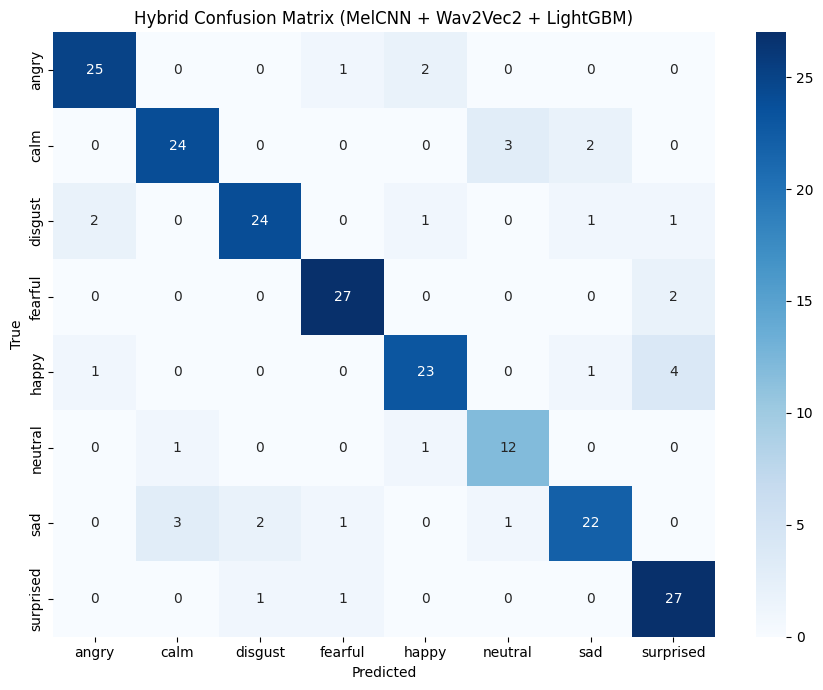


--- Hybrid ROC Curves ---


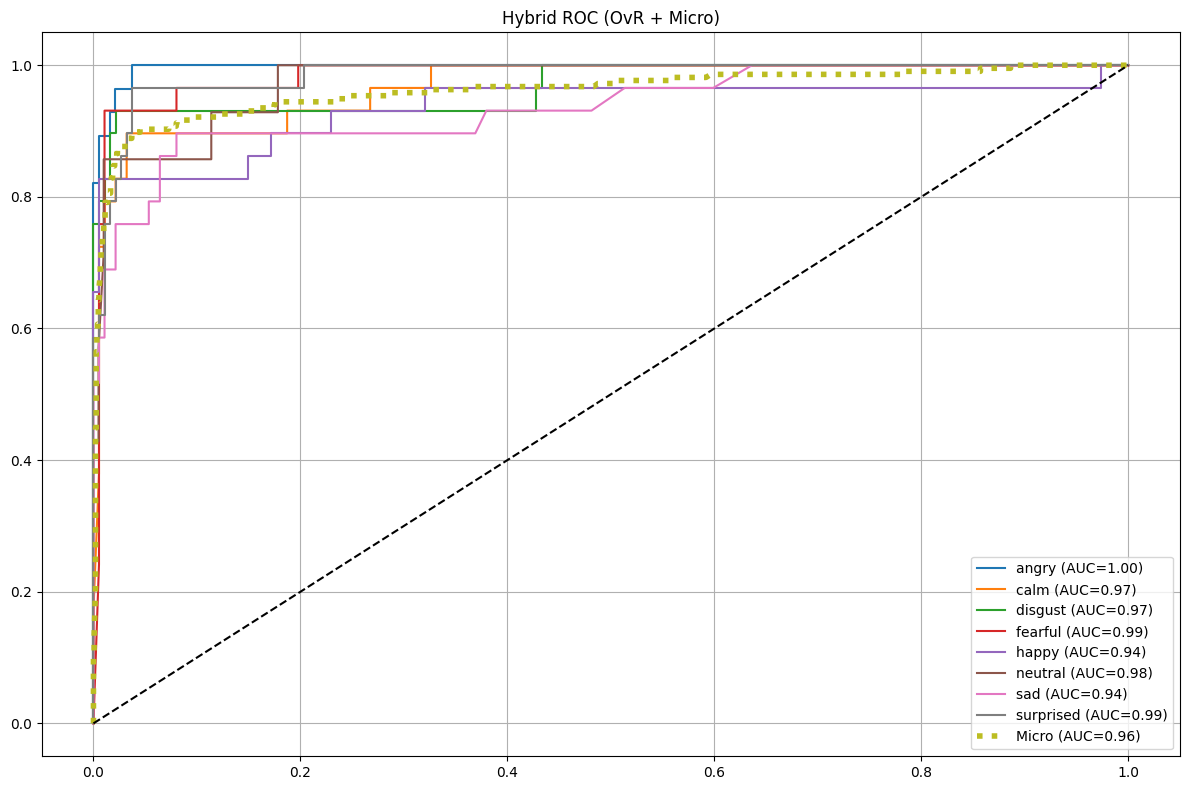


--- Cell 5 Complete ---


In [5]:
# =========================
# CELL 5 (REPLACEMENT): Hybrid Stacking (MelCNN + Wav2Vec2) using LightGBM + Early Stopping
# =========================

print("\n--- Starting Cell 5: Hybrid Stacking (CNN + Wav2Vec2) using LightGBM ---")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

%matplotlib inline

# ------------------------------------------------------------
# 0. REQUIRE PREVIOUS CELLS
# ------------------------------------------------------------
needed = [
    "emotion_class_names", "emotion_label_to_id",
    "train_df_audio", "val_df_audio", "test_df_audio",
    "audio_device", "TARGET_SAMPLE_RATE", "TARGET_NUM_SAMPLES",
    "N_MELS", "N_FFT", "HOP_LENGTH",
    "RAVDESS_AudioDataset", "RAVDESSRawDataset", "w2v_collate",
    "wav2vec_model", "trained_cnn_model"
]

for v in needed:
    if v not in globals():
        raise NameError(f"Missing `{v}` from previous cells. Run Cells 1–4 first.")

trained_audio_model = trained_cnn_model
trained_w2v_model = wav2vec_model
num_classes = len(emotion_class_names)

print(f"Detected {num_classes} classes: {emotion_class_names}")

# ------------------------------------------------------------
# 1. CREATE FIXED-ORDER LOADERS (shuffle=False)
# ------------------------------------------------------------
print("\n--- Creating fixed-order loaders for stacking ---")

# CNN fixed loaders (mel)
train_mel_fixed = RAVDESS_AudioDataset(train_df_audio, mode="mel")
val_mel_fixed   = RAVDESS_AudioDataset(val_df_audio, mode="mel")
test_mel_fixed  = RAVDESS_AudioDataset(test_df_audio, mode="mel")

train_mel_loader_fixed = DataLoader(train_mel_fixed, batch_size=32, shuffle=False, num_workers=0)
val_mel_loader_fixed   = DataLoader(val_mel_fixed, batch_size=32, shuffle=False, num_workers=0)
test_mel_loader_fixed  = DataLoader(test_mel_fixed, batch_size=32, shuffle=False, num_workers=0)

# W2V fixed loaders (raw)
train_raw_fixed = RAVDESSRawDataset(train_df_audio, emotion_label_to_id)
val_raw_fixed   = RAVDESSRawDataset(val_df_audio, emotion_label_to_id)
test_raw_fixed  = RAVDESSRawDataset(test_df_audio, emotion_label_to_id)

train_raw_loader_fixed = DataLoader(train_raw_fixed, batch_size=8, shuffle=False, collate_fn=w2v_collate)
val_raw_loader_fixed   = DataLoader(val_raw_fixed, batch_size=8, shuffle=False, collate_fn=w2v_collate)
test_raw_loader_fixed  = DataLoader(test_raw_fixed, batch_size=8, shuffle=False, collate_fn=w2v_collate)

print("Fixed loaders ready.")

# ------------------------------------------------------------
# 2. HELPERS: Extract probabilities
# ------------------------------------------------------------
def get_cnn_probs_and_labels(model, loader, device):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for mels, labels in tqdm(loader, desc="CNN probs"):
            mels = mels.to(device)
            logits = model(mels)
            probs = F.softmax(logits, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.vstack(all_probs), np.concatenate(all_labels)

def get_w2v_probs_and_labels(model, loader, device):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for input_values, attn_mask, labels in tqdm(loader, desc="W2V probs"):
            input_values = input_values.to(device)
            attn_mask = attn_mask.to(device)

            logits = model(input_values=input_values, attention_mask=attn_mask).logits
            probs = F.softmax(logits, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.vstack(all_probs), np.concatenate(all_labels)

# ------------------------------------------------------------
# 3. EXTRACT BASE PROBS
# ------------------------------------------------------------
print("\n--- Extracting base model probabilities ---")

cnn_train_probs, y_train = get_cnn_probs_and_labels(trained_audio_model, train_mel_loader_fixed, audio_device)
cnn_val_probs,   y_val   = get_cnn_probs_and_labels(trained_audio_model, val_mel_loader_fixed, audio_device)
cnn_test_probs,  y_test  = get_cnn_probs_and_labels(trained_audio_model, test_mel_loader_fixed, audio_device)

w2v_train_probs, y_train_w2v = get_w2v_probs_and_labels(trained_w2v_model, train_raw_loader_fixed, audio_device)
w2v_val_probs,   y_val_w2v   = get_w2v_probs_and_labels(trained_w2v_model, val_raw_loader_fixed, audio_device)
w2v_test_probs,  y_test_w2v  = get_w2v_probs_and_labels(trained_w2v_model, test_raw_loader_fixed, audio_device)

assert np.array_equal(y_train, y_train_w2v), "Train label order mismatch!"
assert np.array_equal(y_val,   y_val_w2v),   "Val label order mismatch!"
assert np.array_equal(y_test,  y_test_w2v),  "Test label order mismatch!"

print("CNN probs:", cnn_train_probs.shape, "| W2V probs:", w2v_train_probs.shape)

# ------------------------------------------------------------
# 4. META FEATURES
# ------------------------------------------------------------
X_train_meta = np.concatenate([cnn_train_probs, w2v_train_probs], axis=1)
X_val_meta   = np.concatenate([cnn_val_probs,   w2v_val_probs], axis=1)
X_test_meta  = np.concatenate([cnn_test_probs,  w2v_test_probs], axis=1)

print("Meta shapes:", X_train_meta.shape, X_val_meta.shape, X_test_meta.shape)

# ------------------------------------------------------------
# 5. LIGHTGBM META-CLASSIFIER + EARLY STOPPING
# ------------------------------------------------------------
print("\n--- Training LightGBM Meta-Classifier ---")

lgb_params = dict(
    objective="multiclass",
    num_class=num_classes,
    boosting_type="gbdt",
    metric="multi_logloss",
    learning_rate=0.02,
    n_estimators=5000,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.2,
    reg_lambda=0.2,
    is_unbalance=True,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

meta_lgb = lgb.LGBMClassifier(**lgb_params)

meta_lgb.fit(
    X_train_meta, y_train,
    eval_set=[(X_val_meta, y_val)],
    eval_metric="multi_logloss",
    callbacks=[
        lgb.early_stopping(stopping_rounds=60, verbose=True),
        lgb.log_evaluation(period=100),
    ]
)

print("Best iteration:", meta_lgb.best_iteration_)

# ------------------------------------------------------------
# 6. EVALUATE HYBRID
# ------------------------------------------------------------
print("\n--- Evaluating Hybrid ---")

hybrid_test_probs = meta_lgb.predict_proba(X_test_meta)
hybrid_test_preds = meta_lgb.predict(X_test_meta)

acc_w2v = accuracy_score(y_test, np.argmax(w2v_test_probs, axis=1))
acc_cnn = accuracy_score(y_test, np.argmax(cnn_test_probs, axis=1))
acc_hybrid = accuracy_score(y_test, hybrid_test_preds)

print(f"Wav2Vec2 Test Acc: {acc_w2v*100:.2f}%")
print(f"MelCNN  Test Acc: {acc_cnn*100:.2f}%")
print(f"Hybrid  Test Acc: {acc_hybrid*100:.2f}%\n")

print("Hybrid Classification Report:")
print(classification_report(y_test, hybrid_test_preds, target_names=emotion_class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, hybrid_test_preds)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=emotion_class_names,
            yticklabels=emotion_class_names)
plt.title("Hybrid Confusion Matrix (MelCNN + Wav2Vec2 + LightGBM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC curves
print("\n--- Hybrid ROC Curves ---")
y_true_bin = label_binarize(y_test, classes=list(range(num_classes)))

plt.figure(figsize=(12,8))
for i, cname in enumerate(emotion_class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], hybrid_test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cname} (AUC={roc_auc:.2f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), hybrid_test_probs.ravel())
roc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle=":", linewidth=4, label=f"Micro (AUC={roc_micro:.2f})")

plt.plot([0,1],[0,1],"k--")
plt.legend()
plt.title("Hybrid ROC (OvR + Micro)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save globals for Cell 6
test_labels = y_test
globals()["w2v_test_probs"] = w2v_test_probs
globals()["cnn_test_probs"] = cnn_test_probs
globals()["hybrid_test_probs"] = hybrid_test_probs

print("\n--- Cell 5 Complete ---")



AUDIO MODEL PERFORMANCE SUMMARY

           Model  Accuracy  Micro_AUC  Precision_macro  Recall_macro  \
0       Wav2Vec2    0.8380     0.9848           0.8372        0.8442   
1  SpecResNetCNN    0.2454     0.5871           0.0965        0.2284   
2         Hybrid    0.8519     0.9615           0.8476        0.8524   

   F1_macro  Precision_weighted  Recall_weighted  F1_weighted  
0    0.8298              0.8574           0.8380       0.8395  
1    0.1328              0.1036           0.2454       0.1426  
2    0.8482              0.8542           0.8519       0.8514  


c:\Users\Suyas\Downloads\cyberbullying_clean\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Suyas\Downloads\cyberbullying_clean\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Suyas\Downloads\cyberbullying_clean\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

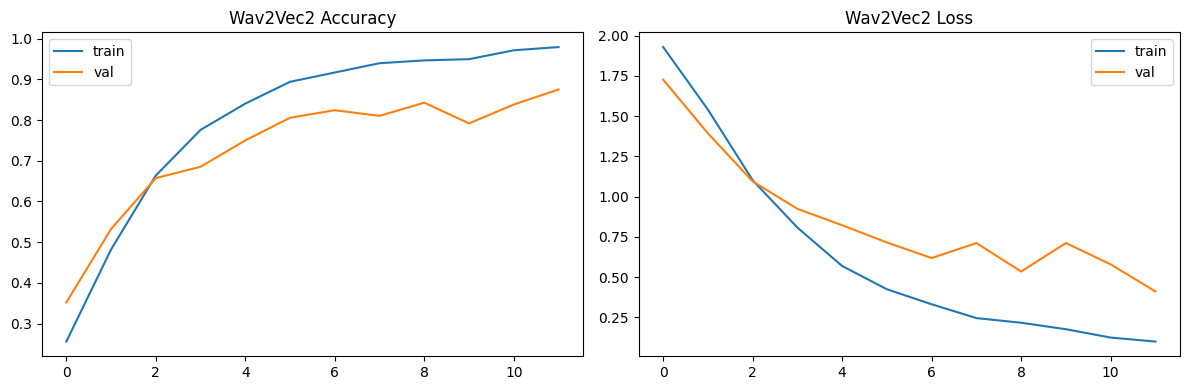

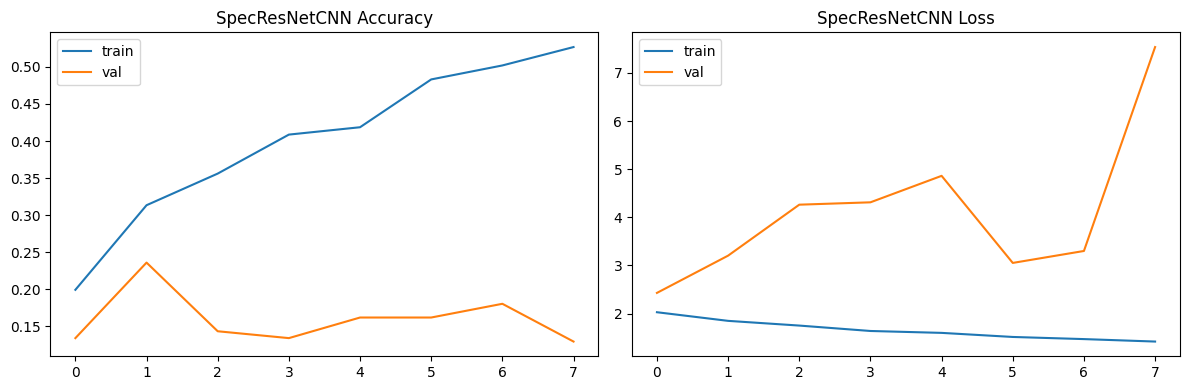

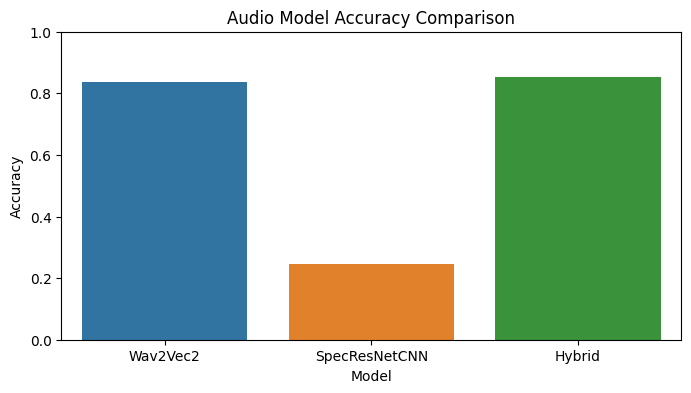

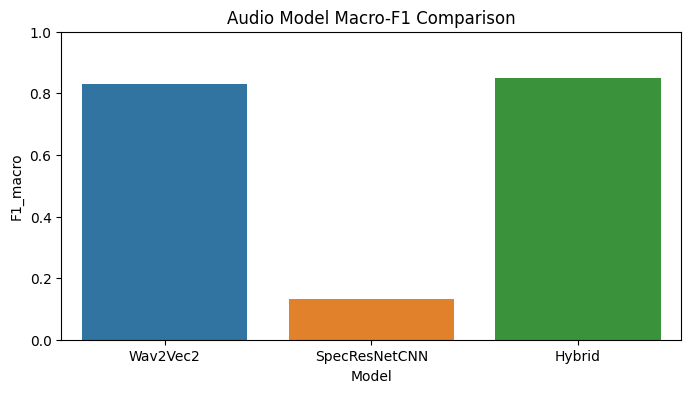

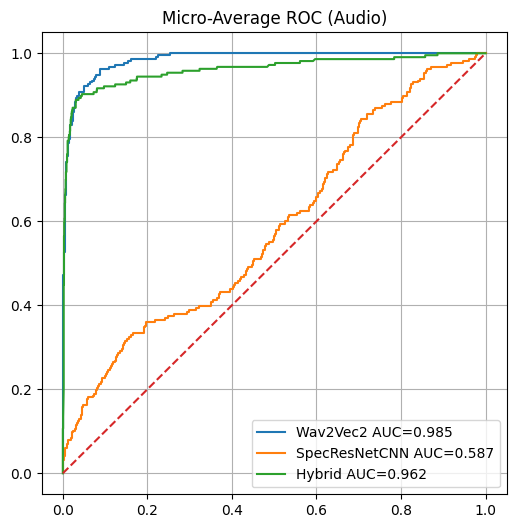

In [6]:
# =========================
# CELL 6 (UPGRADED): Full Metric Comparison + Curves + Graphs
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, classification_report,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# -------------------------
# 0. Safety checks
# -------------------------
needed = [
    "test_labels", "emotion_class_names",
    "w2v_test_probs", "cnn_test_probs", "hybrid_test_probs",
    "history_w2v", "history_cnn",
    "acc_w2v", "acc_cnn", "acc_hybrid"
]
for v in needed:
    if v not in globals():
        raise NameError(f"Missing `{v}` from previous cells. Run Cells 1–5 first.")

y_test = test_labels
num_classes = len(emotion_class_names)

# -------------------------
# 1. Predictions
# -------------------------
w2v_preds = np.argmax(w2v_test_probs, axis=1)
cnn_preds = np.argmax(cnn_test_probs, axis=1)
hybrid_preds = np.argmax(hybrid_test_probs, axis=1)

# -------------------------
# 2. Classification Reports (dict form)
# -------------------------
w2v_rep = classification_report(y_test, w2v_preds, target_names=emotion_class_names, output_dict=True)
cnn_rep = classification_report(y_test, cnn_preds, target_names=emotion_class_names, output_dict=True)
hyb_rep = classification_report(y_test, hybrid_preds, target_names=emotion_class_names, output_dict=True)

# helper to pull macro/weighted stats
def extract_metrics(rep_dict):
    return {
        "Precision_macro": rep_dict["macro avg"]["precision"],
        "Recall_macro": rep_dict["macro avg"]["recall"],
        "F1_macro": rep_dict["macro avg"]["f1-score"],
        "Precision_weighted": rep_dict["weighted avg"]["precision"],
        "Recall_weighted": rep_dict["weighted avg"]["recall"],
        "F1_weighted": rep_dict["weighted avg"]["f1-score"],
    }

# -------------------------
# 3. Micro-AUC for each model
# -------------------------
y_true_bin = label_binarize(y_test, classes=list(range(num_classes)))

def micro_auc(probs):
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), probs.ravel())
    return auc(fpr, tpr)

roc_w2v = micro_auc(w2v_test_probs)
roc_cnn = micro_auc(cnn_test_probs)
roc_hyb = micro_auc(hybrid_test_probs)

# -------------------------
# 4. Build summary table
# -------------------------
summary_rows = []

for name, acc, rep, roc in [
    ("Wav2Vec2", acc_w2v, w2v_rep, roc_w2v),
    ("SpecResNetCNN", acc_cnn, cnn_rep, roc_cnn),   # change name if you kept MelCNN
    ("Hybrid", acc_hybrid, hyb_rep, roc_hyb)
]:
    row = {"Model": name, "Accuracy": acc, "Micro_AUC": roc}
    row.update(extract_metrics(rep))
    summary_rows.append(row)

results_df = pd.DataFrame(summary_rows)

print("\n==============================")
print("AUDIO MODEL PERFORMANCE SUMMARY")
print("==============================\n")
print(results_df.round(4))

# -------------------------
# 5. Training curves
# -------------------------
# curves wav2vec
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_w2v["train_acc"], label="train")
plt.plot(history_w2v["val_acc"], label="val")
plt.title("Wav2Vec2 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_w2v["train_loss"], label="train")
plt.plot(history_w2v["val_loss"], label="val")
plt.title("Wav2Vec2 Loss")
plt.legend()
plt.tight_layout()
plt.show()

# curves cnn
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_cnn["train_acc"], label="train")
plt.plot(history_cnn["val_acc"], label="val")
plt.title("SpecResNetCNN Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn["train_loss"], label="train")
plt.plot(history_cnn["val_loss"], label="val")
plt.title("SpecResNetCNN Loss")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# 6. Comparison bar plots
# -------------------------
plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="Model", y="Accuracy", hue="Model", dodge=False, legend=False)
plt.ylim(0,1)
plt.title("Audio Model Accuracy Comparison")
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="Model", y="F1_macro", hue="Model", dodge=False, legend=False)
plt.ylim(0,1)
plt.title("Audio Model Macro-F1 Comparison")
plt.show()

# -------------------------
# 7. Micro ROC plot
# -------------------------
fpr_w2v, tpr_w2v, _ = roc_curve(y_true_bin.ravel(), w2v_test_probs.ravel())
fpr_cnn, tpr_cnn, _ = roc_curve(y_true_bin.ravel(), cnn_test_probs.ravel())
fpr_h, tpr_h, _     = roc_curve(y_true_bin.ravel(), hybrid_test_probs.ravel())

plt.figure(figsize=(6,6))
plt.plot(fpr_w2v, tpr_w2v, label=f"Wav2Vec2 AUC={roc_w2v:.3f}")
plt.plot(fpr_cnn, tpr_cnn, label=f"SpecResNetCNN AUC={roc_cnn:.3f}")
plt.plot(fpr_h, tpr_h, label=f"Hybrid AUC={roc_hyb:.3f}")
plt.plot([0,1],[0,1],"--")
plt.legend()
plt.title("Micro-Average ROC (Audio)")
plt.grid(True)
plt.show()
